<img src="HW22-1.png" width="1000" height="500">

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import least_squares

In [10]:
twohalo = pd.read_csv("twohalo.dat", names=["rad", "den", "den_err"], sep="\s+")
print(twohalo)

      rad        den   den_err
0     1.0  10.801655  1.023058
1     2.0   4.416248  0.256771
2     3.0   2.419672  0.215507
3     4.0   1.474490  0.267563
4     5.0   1.020668  0.177062
..    ...        ...       ...
95   96.0   0.002174  0.000049
96   97.0   0.002172  0.000486
97   98.0   0.001982  0.000056
98   99.0   0.001938  0.000329
99  100.0   0.002038  0.000297

[100 rows x 3 columns]


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\AGN\AppData\Local\Temp\ipykernel_23772\3888174672.py:1: SyntaxWarning: invalid escape sequence '\s'
  twohalo = pd.read_csv("twohalo.dat", names=["rad", "den", "den_err"], sep="\s+")


In [56]:
def chi2_func(params, r, rho, rho_err, function):
    chi_value1 = function(params, r, rho, rho_err)
    return np.sum(((chi_value1 - rho)/rho_err)**2)

def least(params, r, rho, rho_err, function):
    val1 = function(params[:2], r, rho, rho_err)
    val2 = function(params[2:], r, rho, rho_err)
    val = val1 + val2
    return (val - rho) / rho_err

def NFW(params, r, rho, rho_err):
    rho0, rs = params
    return rho0 / (r/rs * (1 + r/rs)**2)

def uncert_1d(func, x, args, h=1e-5):
    result = (func(x + h, *args) - 2 * func(x, *args) + func(x - h, *args)) / (h**2)
    return np.sqrt(result**-1)

def gradient(func, x, args, h=1e-4):
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp = x[idx]
        x[idx] = tmp + h
        f_x_plux_h = func(x, *args)
        
        x[idx] = tmp
        fx = func(x, *args)
        
        grad[idx] = (f_x_plux_h - fx) / h
        x[idx] = tmp
    return grad

def hessian(func, x, args, h=1e-4):
    hess = np.zeros_like((x, x))
    x_n = x.copy()
    
    for idx in range(x.size):
        x_n[idx] = x[idx] + h
        df_x_plux_h = gradient(func, x_n, args)
        
        df_x = gradient(func, x, args)
        
        hess[:, idx] = (df_x_plux_h - df_x) / h
        x_n = x.copy()
    return hess

def uncert_2d(func, x, args, h=1e-3):
    hess = hessian(func, x, args, h)
    return np.sqrt(np.diag(np.linalg.inv(hess)))

def reduced_chi2_func(func, params, args):
    model = func(params, *args)
    chi = np.sum(((model - args[1])/args[2])**2)
    freedom = len(args[0]) - len(params)
    return chi / freedom

In [82]:
# Calculate parameters rho1, rho2, rs1, rs2
result = least_squares(least, x0=[1e-2, 1e-2, 1e-2, 1e-2], args=(twohalo.rad, twohalo.den, twohalo.den_err, NFW), method='lm')
print(result.x)

[ 0.21317294 23.57880968  3.40078176  3.30039845]


In [143]:
# Get uncertainties
print(result.jac)
cov = np.linalg.inv(result.jac.T @ result.jac)
uncert = np.sqrt(np.diag(cov))
print(f"\n\nUncertainties of parameters(rho1, rho2, rs1, rs2): {uncert}")

[[2.12101492e+01 2.07361730e-01 1.90012213e+00 2.86848924e+00]
 [3.90148172e+01 4.07887261e-01 2.49176277e+00 4.50517970e+00]
 [2.87019362e+01 3.18068809e-01 1.40081153e+00 2.81801475e+00]
 [1.61038313e+01 1.87825828e-01 6.30261257e-01 1.36109731e+00]
 [1.81293490e+01 2.21257041e-01 5.89394518e-01 1.33899849e+00]
 [2.22073284e+01 2.82226557e-01 6.16010454e-01 1.45373968e+00]
 [8.50391900e+01 1.12082345e+00 2.05534963e+00 4.99640308e+00]
 [5.12503458e+01 6.98111545e-01 1.09757521e+00 2.73225927e+00]
 [9.84983968e+01 1.38252425e+00 1.89493675e+00 4.80990244e+00]
 [3.93147151e+01 5.67143683e-01 6.87210703e-01 1.77291160e+00]
 [2.42546910e+01 3.58797754e-01 3.88913519e-01 1.01725230e+00]
 [4.51041319e+01 6.82852556e-01 6.68847590e-01 1.77024660e+00]
 [1.97415636e+01 3.05344062e-01 2.72632568e-01 7.29014827e-01]
 [2.46065781e+02 3.88223603e+00 3.18389357e+00 8.59046846e+00]
 [4.26770786e+02 6.85876630e+00 5.20121409e+00 1.41451412e+01]
 [2.63189142e+01 4.30328307e-01 3.03524930e-01 8.313065

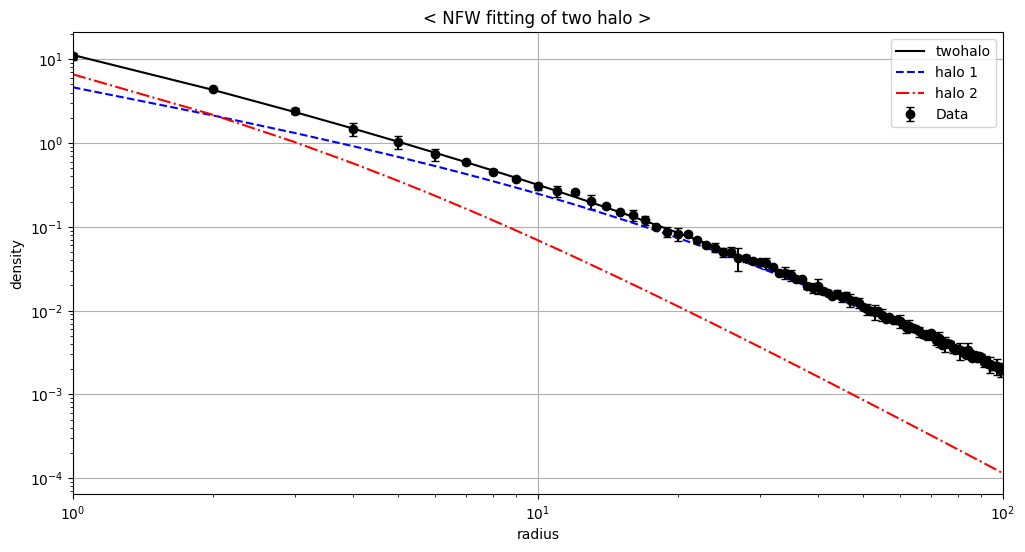

In [173]:
nfw1 = NFW(result.x[:2], twohalo.rad, twohalo.den, twohalo.den_err)
nfw2 = NFW(result.x[2:], twohalo.rad, twohalo.den, twohalo.den_err)
nfw_two = nfw1 + nfw2

plt.figure(figsize=(12, 6))
plt.title("< NFW fitting of two halo >")
plt.xlabel("radius")
plt.ylabel("density")
plt.grid()
plt.xlim(1, 100)
plt.yscale('log')
plt.xscale('log')
plt.errorbar(twohalo.rad, twohalo.den, yerr=twohalo.den_err, fmt='o', label='Data', color='black', capsize=3)
plt.plot(twohalo.rad, nfw_two, label='twohalo', color='black')
plt.plot(twohalo.rad, nfw1, label='halo 1', color='blue', linestyle='--')
plt.plot(twohalo.rad, nfw2, label='halo 2', color='red', linestyle='-.')
plt.legend()

Hessian uncertainty: [0.04086458 1.49700876 1.7510331  1.12265784]


TypeError: arctan2() takes from 2 to 3 positional arguments but 4 were given

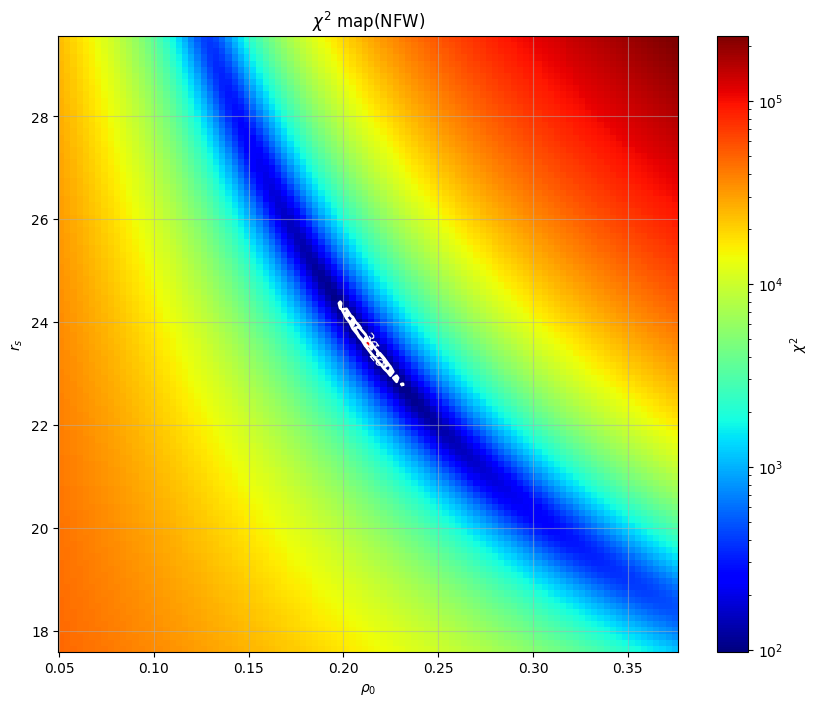

In [167]:
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

def twohalo_func(params, r, rho, rho_err):
    rho1, rs1, rho2, rs2 = params
    return NFW([rho1, rs1], r, rho, rho_err) + NFW([rho2, rs2], r, rho, rho_err)

X, Y = np.meshgrid(
    np.linspace(result.x[0] - 4 * uncert[0], result.x[0] + 4 * uncert[0], 100),
    np.linspace(result.x[1] - 4 * uncert[1], result.x[1] + 4 * uncert[1], 100)
)
z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        params = [X[i, j], Y[i, j], result.x[2], result.x[3]]
        z[i, j] = chi2_func(params, twohalo['rad'], twohalo['den'], twohalo['den_err'], twohalo_func)
        
chi2_min = np.min(z)
levs = [chi2_min + chi2.ppf(0.68, df=2), chi2_min + chi2.ppf(0.95, df=2), chi2_min + chi2.ppf(0.99, df=2)]

plt.figure(figsize=(10, 8))
plt.grid(alpha=0.5)
plt.imshow(
    z,
    norm=LogNorm(),
    extent=(X.min(), X.max(), Y.min(), Y.max()),
    origin='lower',
    cmap='jet',
    aspect='auto'
)
plt.xlabel(r'$\rho_0$'); plt.ylabel(r'$r_s$')
plt.title(r'$\chi^2$' + " map(NFW)")
plt.colorbar(label=r'$\chi^2$')
#------------------------------------------------------------------------------------------------------
plt.scatter(result.x[0], result.x[1], color='red', label='fitting result', marker='*')
#------------------------------------------------------------------------------------------------------
max_post = np.max(z)
tags = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
cs = plt.contour(X, Y, z, levels=levs, colors='white', linewidths=2)
plt.clabel(cs, inline=True, fontsize=10, fmt={levs[0]: tags[0], levs[1]: tags[1], levs[2]: tags[2]})
#------------------------------------------------------------------------------------------------------

print("Hessian uncertainty:", uncert)

vals, vecs = np.linalg.eigh(cov)
order = vals.argsort()[::-1]
vals, vecs = vals[order], vecs[:, order]
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

for nsig, color, tag in zip([1,2,3], ['red','red','red'], [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']):
    width, height = 2 * nsig * np.sqrt(vals)
    ellipse = Ellipse(
        (result.x[0], result.x[1]), width, height, angle=theta,
        edgecolor=color, fc='None', lw=2, alpha=0.6
    )
    plt.gca().add_patch(ellipse)
    angle_rad = np.radians(theta)
    x_tag = result.x[0] + (width/2) * np.cos(angle_rad)
    y_tag = result.x[1] + (width/2) * np.sin(angle_rad)
    plt.gca().text(
        x_tag, y_tag, tag, color='yellow', fontsize=15, weight='bold',
        va='center', ha='center'
    )